In [65]:
from abc import ABC
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import torch
from torchtext import data
import torch.nn as nn
import spacy

## 数据处理部分

In [66]:
# 读入数据集,默认sep=','
test = pd.read_csv("test.csv") # 测试数据集
train = pd.read_csv("train.csv") # 训练数据集

In [67]:
print(test.shape)
print(train.shape)

(3263, 4)
(7613, 5)


* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [68]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [69]:
# 去掉'id','kewword','location'等无关字段
train.drop(columns=['id','keyword','location'], inplace=True)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [70]:
def normalise_text (text):
    """使用正则表达式去掉噪音"""
    text = text.str.lower() # 小写化
    text = text.str.replace(r"\#", "") # 将字符#替换为""
    text = text.str.replace(r"[a-zA-z]+://[^\s]*", "URL")  # 过滤网站
    text = text.str.replace(r"\@", "") # 将字符@替换为""
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ") # 去掉除数字,字母,',`,"之外的字符
    text = text.str.replace("\s{2,}", " ") # 将空白字符[\f\n\r\t\v]出现次数>=2的替换为" "
    return text

In [71]:
train['text'].iloc[40]

'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw'

In [72]:
train["text"] = normalise_text(train["text"])

In [73]:
train['text'].iloc[40] # 使用normalise_text方法后噪音得到消除

'check these out URL URL URL URL nsfw'

In [74]:
train_df, valid_df = train_test_split(train, test_size=0.25) # 数据集留出法划分

In [75]:
spacy_en = spacy.load('en_core_web_sm') # 加载spacy英文库
spacy_en

In [76]:
def tokenizer(text):
    """定义分词操作"""
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = data.Field(tokenize =tokenizer, include_lengths=True)
LABEL = data.Field(sequential=False, unk_token=None,
                    use_vocab=False) # 字段target已经为数字,故这里可以设置use_vocal=False

C:\Users\duanm\anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [77]:
class DataFrameDataset(data.Dataset):
    """"重写一个处理DataFrame数据类型的Dataset(通过模仿data.Dataset类)"""
    def __init__(self, df, fields_f, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields_f))
        super().__init__(examples, fields_f, **kwargs)

    @staticmethod
    def sort_key(ex):
        """数据集的排序方法,这里根据文本长度"""
        return len(ex.text)

    @classmethod
    def splits(cls, train_df_f=None, val_df_f=None, test_df_f=None, **kwargs):
        train_data = None if train_df_f is None else cls(
            train_df.copy(), **kwargs)
        val_data = None if val_df_f is None else cls(
            val_df_f.copy(), **kwargs)
        test_data = None if test_df_f is None else cls(
            test_df_f.copy(), is_test=True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data)
                     if d is not None)

In [78]:
fields = [('text',TEXT),
          ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(train_df_f=train_df, val_df_f=valid_df, fields_f=fields)

C:\Users\duanm\anaconda3\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [79]:
train_ds.examples[15].__dict__ # 测试DataFrameDataset类测试成功

{'text': ['wreck',
  '?',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  'wreck',
  '?'],
 'label': 0}

In [80]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_ds,
                 vectors_cache='D:/PythonCode/F_PyTorch/高阶操作及深度学习相关理论/torchtext自然语言处理/vector_cache', # 预训练词向量缓存位置
                 max_size=MAX_VOCAB_SIZE,
                 vectors='glove.6B.200d', # 预训练词向量
                 unk_init=torch.Tensor.zero_)

In [81]:
print(TEXT.vocab.stoi['good']) # 单词表构建成功
print(TEXT.vocab.stoi.keys())

157
dict_keys(['<unk>', '<pad>', 'URL', 'the', '?', 'a', 'to', 'in', 'i', 'of', 'and', "'", '!', 'is', 'you', 'for', 'on', "'s", 'it', 'my', 'that', 'at', 'with', 'by', 'this', "n't", 'be', 'from', 'have', 'are', 'was', ')', 'amp', 'do', 'up', '(', 'like', 'as', 'just', 'so', 'not', 'me', 'your', 'but', 'we', 'all', 'has', 'no', 'out', 'will', 'when', "'m", 'after', 'an', 'fire', 'get', 'if', 'new', 'they', 'he', 'more', 'via', 'what', '2', 'now', 's', 'or', 'news', 'there', 'about', 'one', 'been', 'over', 'people', 'how', 'who', 'can', ' ', 'video', 'into', 'disaster', 'police', '3', 'than', 'u', 'emergency', 'm', 'got', 'were', 'body', 'would', 'ca', 'still', 'know', "'re", 'her', 'crash', 'day', 'them', 'world', 'buildings', 'some', 'storm', 'why', '5', 'burning', 'his', '1', 'california', 'had', 'man', 'back', 'time', 'us', 'love', 'suicide', 'year', 'bomb', 'fires', '4', 'did', 'old', 'first', 'go', 'going', 'nuclear', 'see', 'their', 'killed', 'rt', 'two', 'may', 'off', 'here', '

In [82]:
print(TEXT.vocab.vectors)
print(TEXT.vocab.vectors.shape) # 词向量矩阵维度(单词个数,词向量维度)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.5852,  0.2087, -0.2828,  ...,  0.3333,  0.9325, -0.0848],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1776,  0.2225,  0.3361,  ...,  0.5330,  0.6103, -0.4537]])
torch.Size([14134, 200])


In [83]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds),
    shuffle=True,
    sort_within_batch=True,
    batch_size=BATCH_SIZE,
    device=device)

C:\Users\duanm\anaconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [94]:
# 输出测试
for batch in train_iterator:
    print(batch.text) # batch.text这里为元组类型
    print(batch.text[0].shape)
    print(batch.label)
    print(batch.label.dtype)
    break

(tensor([[   5,   77, 1931,  ...,   57, 1484,  785],
        [3444, 4737, 8362,  ..., 2072,  352,  285],
        [2545, 4054, 2255,  ...,  255, 6258,  349],
        ...,
        [   4,  100,   47,  ...,  117,  566,  746],
        [   4,    4, 1659,  ..., 1529,    2,    2],
        [   2, 3937,    2,  ...,    2,    2,   67]]), tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12]))
torch.Size([12, 128])
tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1

C:\Users\duanm\anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [85]:
print(TEXT.pad_token)
print(TEXT.unk_token)
print(TEXT.vocab.stoi[TEXT.pad_token])
print(TEXT.vocab.stoi[TEXT.unk_token])

# '<pad>','<unk>'在词向量矩阵中均为0张量
print(TEXT.vocab.vectors[TEXT.vocab.stoi[TEXT.pad_token]])
print(TEXT.vocab.vectors[TEXT.vocab.stoi[TEXT.unk_token]])

<pad>
<unk>
1
0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

## 模型构建部分

In [86]:
num_epochs = 25 # 训练轮数
learning_rate = 0.001 # 学习率
pretrained_embeddings = TEXT.vocab.vectors # 预训练词向量句子
HIDDEN_DIM = 256 # LSTM隐藏层维度大小
N_LAYERS = 2 # LSMT层数
DROPOUT = 0.2 # LSTM网络的dropout参数
BIDIRECTIONAL = True # 是否为设置为双向循环神经网络

In [87]:
class LSTM_net(nn.Module, ABC):
    def __init__(self, pre_trained_embed, hidden_size, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pre_trained_embed) # 直接导入预训练词向量矩阵
        self.rnn = nn.LSTM(pre_trained_embed.shape[1], hidden_size, num_layers=n_layers,
                           bidirectional=bidirectional, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        # text.shape = (T, N)
        embedded = self.embedding(text) # 故embedded.shape=(T, N, C)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths) # 打包,可以提高效率和模型精准性
        packed_output, (hidden, cell) = self.rnn(packed_embedded) # Packs a Tensor containing padded sequences of variable length
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)) # 合并最后一层正向和反向,易知:hidden.shape=[batch, hidden_size*2]
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
        return output

In [88]:
net = LSTM_net(pretrained_embeddings, HIDDEN_DIM,
                 N_LAYERS, BIDIRECTIONAL, DROPOUT)
net

LSTM_net(
  (embedding): Embedding(14134, 200)
  (rnn): LSTM(200, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [89]:
net.to(device)
criterion = nn.BCEWithLogitsLoss() # 损失函数
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # 优化器

In [90]:
def binary_accuracy(preds, y):
    """每一个batch的精准度"""
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = rounded_preds == y
    correct = correct.to(dtype=torch.float32)
    accuray = correct.sum() / len(correct)
    return accuray

In [91]:
def train(model, iterator):
    """模型训练"""
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_tr in iterator:
        text, text_lengths = batch_tr.text
        batch_tr.label = batch_tr.label.to(dtype=torch.float32)

        predictions = model(text, text_lengths).squeeze(1) # 向量
        loss_tr = criterion(predictions, batch_tr.label)
        optimizer.zero_grad()
        acc_tr = binary_accuracy(predictions, batch_tr.label)

        loss_tr.backward()
        optimizer.step()

        epoch_loss += loss_tr.item()
        epoch_acc += acc_tr.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [92]:
def evaluate(model, iterator):
    """模型评估"""
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch_ev in iterator:
            text, text_lengths = batch_ev.text
            batch_ev.label = batch_ev.label.to(dtype=torch.float32)

            predictions = model(text, text_lengths).squeeze(1)
            acc_ev = binary_accuracy(predictions, batch_ev.label)
            epoch_acc += acc_ev.item()
    return epoch_acc / len(iterator)

In [93]:
t = time.time() # 训练时间
loss = [] # 训练数据集损失
acc = [] # 训练数据集准确度
val_acc = [] # 评估数据集损失

for epoch in range(num_epochs):
    train_loss, train_acc = train(net, train_iterator)
    valid_acc = evaluate(net, valid_iterator)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.568 | Train Acc: 70.53%
	 Val. Acc: 77.26%
	Train Loss: 0.492 | Train Acc: 75.37%
	 Val. Acc: 77.77%
	Train Loss: 0.468 | Train Acc: 77.17%
	 Val. Acc: 79.14%
	Train Loss: 0.450 | Train Acc: 78.67%
	 Val. Acc: 79.82%
	Train Loss: 0.435 | Train Acc: 79.06%
	 Val. Acc: 78.53%
	Train Loss: 0.419 | Train Acc: 79.75%
	 Val. Acc: 78.97%
	Train Loss: 0.397 | Train Acc: 80.36%
	 Val. Acc: 78.45%
	Train Loss: 0.378 | Train Acc: 81.87%
	 Val. Acc: 77.87%
	Train Loss: 0.360 | Train Acc: 82.12%
	 Val. Acc: 76.47%
	Train Loss: 0.341 | Train Acc: 83.65%
	 Val. Acc: 76.48%
	Train Loss: 0.321 | Train Acc: 84.13%
	 Val. Acc: 77.15%
	Train Loss: 0.278 | Train Acc: 85.18%
	 Val. Acc: 76.48%
	Train Loss: 0.254 | Train Acc: 87.33%
	 Val. Acc: 77.88%
	Train Loss: 0.235 | Train Acc: 88.29%
	 Val. Acc: 76.60%
	Train Loss: 0.231 | Train Acc: 88.96%
	 Val. Acc: 77.27%
	Train Loss: 0.214 | Train Acc: 89.25%
	 Val. Acc: 76.73%
	Train Loss: 0.207 | Train Acc: 89.05%
	 Val. Acc: 75.02%
	Train Loss: 0

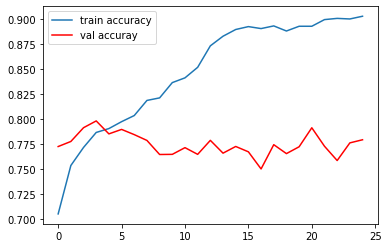

In [98]:
import matplotlib.pyplot as plt

plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='val accuray', color='red')
plt.legend()
plt.show()